In [59]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import gcsfs
import sys
import rasterio as rio
import logging
from pathlib import Path
from typing import List, Union
import geopandas as gpd
import pandas as pd
import json
import shapely
from shapely.geometry import shape
from rasterio.warp import Resampling
import requests
from tqdm import tqdm
import rasterio.mask
import rasterio.merge
import time

sys.path.append("/home/nick/C2S-Python-API/")
from c2s.external.stac.warp_to import warp_to
from c2s.hydrology.dem_upsample import upsample_fm_with_dem

In [5]:
fs = gcsfs.GCSFileSystem()

## DEM prep utilities from pf_ml

In [29]:
logger = logging.getLogger(__name__)

DEFAULT_HAND_DIR = Path("/data/static/hand")
HAND_ENDPOINT = "https://web.corral.tacc.utexas.edu/nfiedata/HAND"
HUC_SHP_DIR = Path("/data/static/hand/huc_boundaries")


def get_huc_geometry_map(huc_shp_dir: Union[str, Path] = HUC_SHP_DIR) -> pd.DataFrame:
    """get a mapping between the HUC watershed id and it's bounding geometry
    Args:
        huc_shp_dir (Union[str, Path], optional): directory where the shapefiles for each huc are saved. Defaults to HUC_SHP_DIR.
    Returns:
        pd.DataFrame: geopandas dataframe with columns ['huc', 'geometry']
    """
    huc_shp_dir = Path(huc_shp_dir)
    shpfiles = list(huc_shp_dir.glob("*.shp"))
    shp_hucs = [i.stem.split("-")[0] for i in shpfiles]
    all_dfs = [gpd.read_file(i) for i in shpfiles]
    df_hucs = pd.concat(all_dfs)
    df_hucs["huc"] = shp_hucs
    return df_hucs


def list_hucs_that_overlap_geometry(geometry: shapely.geometry, df_hucs: pd.DataFrame = None) -> List[str]:
    """find the set of HUC watershed ids that overlap with a provided geometry
    The geometry provided must be in a LAT/LON crs
    Args:
        geometry (shapely.geometry): geometry in LAT/LON coords to find intersections with
        df_hucs (pd.DataFrame): If you already have a mapping between hucs and geometries, pass it in (Optional)
    Returns:
        List[str]: list of HUC lids
    """
    df_hucs = get_huc_geometry_map()
    df_hucs["intersects_with_geo"] = df_hucs.geometry.apply(lambda x: x.intersects(geometry))
    return df_hucs[df_hucs.intersects_with_geo].huc.tolist()


def download_hand_for_huc(huc: str):
    download_field_for_huc(huc, extension="hand.tif", output_dir=DEFAULT_HAND_DIR)


def download_field_for_huc(huc: str, extension: str, output_dir=DEFAULT_HAND_DIR):
    """
    see https://web.corral.tacc.utexas.edu/nfiedata/ for appropriate extension
    """
    output_dir = Path(output_dir)
    field_url = f"{HAND_ENDPOINT}/{huc}/{huc}{extension}"
    local_file = output_dir / f"{huc}{extension}"
    logger.info(f"Downloading {field_url} to {local_file}")
    urlretrieve(field_url, local_file)


def prep_hand_for_one_example(
    reference_tif: str,
    mosaic_hand_tif: str,
    resampling_str: str = "average",
    clip_to_us: bool = True,
    debug: bool = False,
):
    """Create a HAND tif matching the reference_tif (same grid, bounds, res, etc.)
    Args:
        reference_tif (str): chip for which to create a matching HAND chip
        mosaic_hand_tif (str): HAND mosiac path
        resampling (str, optional): string representation of resampling method, one of `average`, `nearest`, `bilinear`. Defaults to "average".
        clip_to_us (bool, optional): clip the HAND chip to the US border, using the same US bounds as in the flood map prep
            i.e. Section 2 here: https://github.com/cloudtostreet/pf_ml/blob/main/notebooks/dailyflood_v2/05__2022-07-11-tn-training-data-qc.ipynb
        debug (bool, optional): enable extra logging; files are still saved. Defaults to False.
    Returns:
        Path: file path of new HAND chip
    """
    reference_tif = Path(reference_tif)
    output_dir = reference_tif.parent

    output_fname = output_dir / f"hand_{resampling_str}.tif"
    if debug:
        logger.info(output_fname)

    with rio.open(reference_tif) as src:
        dst_bounds = src.bounds
    with rio.open(mosaic_hand_tif) as src:
        nodata = src.nodata
        profile = src.profile

    res = 2000 / 111000
    dst_crs = 4269
    warped_tif = warp_to(
        tif_list=[mosaic_hand_tif],
        dst_bounds=dst_bounds,
        dst_crs=dst_crs,
        src_nodata=nodata,
        dst_nodata=nodata,
        profile=profile,
        res=res,
        resampling=Resampling.__members__[resampling_str],
        output_dir=output_dir,
    )
    warped_tif.rename(output_fname)

    if clip_to_us:
        # load US border geometry and buffer slightly
        df_us = gpd.read_file(
            "/data/static/Longitude_Graticules_and_World_Countries_Boundaries-shp/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp"
        )
        df_us = df_us[df_us.CNTRY_NAME == "United States"]
        df_us.geometry = df_us.geometry.buffer(0.05)

        output_fname = clip_us_coastline(output_fname, df_us.geometry)

    return output_fname


def urlretrieve(url: str, output_file: str):
    """Large file retrieval with progressbar
    From: https://github.com/psf/requests/issues/1632#issuecomment-25299162
    Args:
        url (str): endpoint you're downloading from
        output_file (str): where the endpoint will be downloaded to
    """
    r = requests.get(url, stream=True)
    r.raise_for_status()  # Replace this with better error handling.
    total_size_in_bytes = int(r.headers.get("content-length", 0))
    block_size = 1024  # 1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)

    with open(output_file, "wb") as f:
        for chunk in r.iter_content(block_size):
            progress_bar.update(len(chunk))
            f.write(chunk)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        logger.error(f"something went wrong when grabbing {url}")

## Harvey (Houston)

### Download files

In [7]:
outdir = "/home/nick/C2S-Python-API/data/dem_upsample/harvey"
os.makedirs(outdir, exist_ok=True)

In [6]:
fs.ls("gs://daily_flood_v2_data/events/houston_harvey")

['daily_flood_v2_data/events/houston_harvey/20170823.tif',
 'daily_flood_v2_data/events/houston_harvey/20170824.tif',
 'daily_flood_v2_data/events/houston_harvey/20170825.tif',
 'daily_flood_v2_data/events/houston_harvey/20170826.tif',
 'daily_flood_v2_data/events/houston_harvey/20170827.tif',
 'daily_flood_v2_data/events/houston_harvey/20170828.tif',
 'daily_flood_v2_data/events/houston_harvey/20170829.tif',
 'daily_flood_v2_data/events/houston_harvey/20170830.tif',
 'daily_flood_v2_data/events/houston_harvey/20170831.tif',
 'daily_flood_v2_data/events/houston_harvey/20170901.tif',
 'daily_flood_v2_data/events/houston_harvey/20170902.tif',
 'daily_flood_v2_data/events/houston_harvey/20170903.tif',
 'daily_flood_v2_data/events/houston_harvey/20170904.tif',
 'daily_flood_v2_data/events/houston_harvey/sales_demo']

In [15]:
fm_paths = []

for gs_path in fs.ls("gs://daily_flood_v2_data/events/houston_harvey"):
    if not gs_path.endswith(".tif"):
        continue
    dst_path = f"{outdir}/{os.path.basename(gs_path)}"
    print(dst_path)
    fs.get(
        gs_path,
        dst_path
    )
    fm_paths.append(dst_path)

/home/nick/C2S-Python-API/data/dem_upsample/harvey/20170823.tif
/home/nick/C2S-Python-API/data/dem_upsample/harvey/20170824.tif
/home/nick/C2S-Python-API/data/dem_upsample/harvey/20170825.tif
/home/nick/C2S-Python-API/data/dem_upsample/harvey/20170826.tif
/home/nick/C2S-Python-API/data/dem_upsample/harvey/20170827.tif
/home/nick/C2S-Python-API/data/dem_upsample/harvey/20170828.tif
/home/nick/C2S-Python-API/data/dem_upsample/harvey/20170829.tif
/home/nick/C2S-Python-API/data/dem_upsample/harvey/20170830.tif
/home/nick/C2S-Python-API/data/dem_upsample/harvey/20170831.tif
/home/nick/C2S-Python-API/data/dem_upsample/harvey/20170901.tif
/home/nick/C2S-Python-API/data/dem_upsample/harvey/20170902.tif
/home/nick/C2S-Python-API/data/dem_upsample/harvey/20170903.tif
/home/nick/C2S-Python-API/data/dem_upsample/harvey/20170904.tif


In [19]:
with fs.open("gs://daily_flood_v2_data/flood_maps-inference/250m/197902030300/30.425084_-96.009623_29.218970_-94.626389/v0_02/20221107-153133/197902030300__30.425084_-96.009623_29.218970_-94.626389.geojson") as f:
    houston_geojson = json.load(f)

In [ ]:
hucs = list_hucs_that_overlap_geometry(shape(houston_geojson["geometry"]))

In [32]:
# download matching DEMs
dem_dir = "/data/static/ned/10m/original/"
os.makedirs(dem_dir, exist_ok=True)

for huc in hucs:
    if not os.path.exists(os.path.join(dem_dir, f"{huc}.tif")):
        print(f"missing {huc}")
        download_field_for_huc(huc, ".tif", dem_dir)
    else:
        print(f"already have {huc}")

missing 120200


100%|████████████████████████████████████████████████████████████████████████████████████████| 9.27G/9.27G [05:17<00:00, 29.2MiB/s]


missing 120904


100%|████████████████████████████████████████████████████████████████████████████████████████| 1.08G/1.08G [00:38<00:00, 28.3MiB/s]


missing 120302


100%|████████████████████████████████████████████████████████████████████████████████████████| 3.41G/3.41G [02:04<00:00, 27.3MiB/s]


missing 120402


100%|████████████████████████████████████████████████████████████████████████████████████████| 3.78G/3.78G [02:18<00:00, 27.3MiB/s]


missing 120701


100%|████████████████████████████████████████████████████████████████████████████████████████| 7.42G/7.42G [04:05<00:00, 30.2MiB/s]


missing 120401


100%|████████████████████████████████████████████████████████████████████████████████████████| 3.01G/3.01G [01:39<00:00, 30.4MiB/s]


In [34]:
# if the extent of all the images is the same, we can just prepare the DEM once
fm_path = fm_paths[0]
with rasterio.open(fm_path, "r") as src:
    bounds = src.bounds
    
for fm_path in fm_paths[1:]:
    with rasterio.open(fm_path, "r") as src:
        assert src.bounds == bounds

### Prepare DEM

In [37]:
os.getcwd()

'/home/nick/C2S-Python-API/notebooks'

In [41]:
houston_shape = shape(houston_geojson["geometry"])

clipped_dems = []
for huc in hucs:
    huc_path = f"{dem_dir}/{huc}.tif"
    print(huc_path)
    with rasterio.open(huc_path) as src:
        crop_arr, crop_transform = rasterio.mask.mask(src, [houston_shape], crop=True)
        out_profile = src.profile
    # save the cropped file
    out_profile["transform"] = crop_transform
    out_profile["height"] = crop_arr.shape[1]
    out_profile["width"] = crop_arr.shape[2]

    out_name = f"/home/nick/C2S-Python-API/data/dem_upsample/harvey/{huc}_crop.tif"
    with rasterio.open(out_name, "w", **out_profile) as dst:
        dst.write(crop_arr)
    clipped_dems.append(out_name)

/data/static/ned/10m/original//120200.tif
/data/static/ned/10m/original//120904.tif
/data/static/ned/10m/original//120302.tif
/data/static/ned/10m/original//120402.tif
/data/static/ned/10m/original//120701.tif
/data/static/ned/10m/original//120401.tif


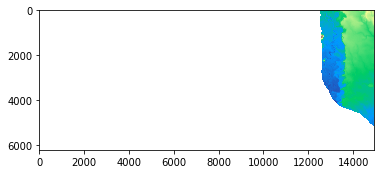

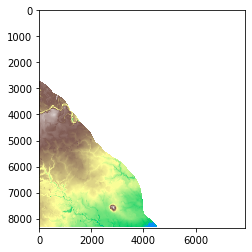

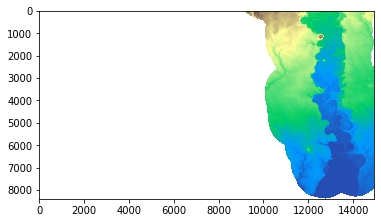

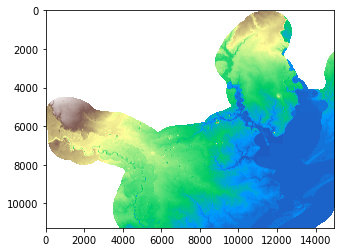

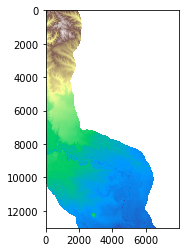

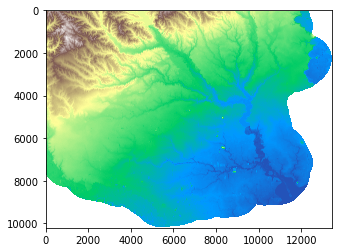

In [42]:
for dem in clipped_dems:
    arr = rasterio.open(dem).read(1)
    plt.imshow(np.ma.masked_less(arr, -100), cmap="terrain")
    plt.show()

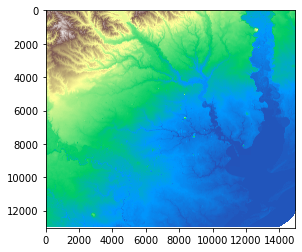

In [45]:
# merge them

merged_arr, merged_transform = rasterio.merge.merge(clipped_dems)

# visualize merged DEM
plt.imshow(np.ma.masked_less(merged_arr[0], -100), cmap="terrain")
plt.show()

# save to disk
profile = out_profile
profile["transform"] = merged_transform
profile["height"] = merged_arr.shape[1]
profile["width"] = merged_arr.shape[2]
with rasterio.open("/home/nick/C2S-Python-API/data/dem_upsample/harvey/merged_dem_10m.tif", "w", **profile) as dst:
    dst.write(merged_arr)

In [46]:
# run the crop one more time, just for extra security
with rasterio.open("/home/nick/C2S-Python-API/data/dem_upsample/harvey/merged_dem_10m.tif", "r") as src:
    crop_arr, crop_transform = rasterio.mask.mask(src, [houston_shape], crop=True)
    out_profile = src.profile
# save the cropped file
out_profile["transform"] = crop_transform
out_profile["height"] = crop_arr.shape[1]
out_profile["width"] = crop_arr.shape[2]

with rasterio.open("/home/nick/C2S-Python-API/data/dem_upsample/harvey/merged_dem_10m_crop.tif", "w", **out_profile) as dst:
    dst.write(crop_arr)

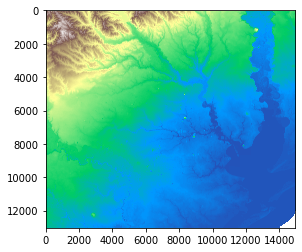

In [47]:
plt.imshow(np.ma.masked_less(crop_arr[0], -100), cmap="terrain")
plt.show()

In [48]:
# how close is the upper-left pixel of the merged DEM to the flood maps?
merged_dem_10m_path = Path("/home/nick/C2S-Python-API/data/dem_upsample/harvey/merged_dem_10m_crop.tif")

with rasterio.open(merged_dem_10m_path, "r") as src:
    merged_dem_profile = src.profile
with rasterio.open(fm_path, "r") as src:
    fm_profile = src.profile
    
print(merged_dem_profile["transform"])
print(fm_profile["transform"])

| 0.00, 0.00,-96.01|
| 0.00,-0.00, 30.43|
| 0.00, 0.00, 1.00|
| 0.00, 0.00,-96.01|
| 0.00,-0.00, 30.43|
| 0.00, 0.00, 1.00|


In [49]:
print(merged_dem_profile["nodata"])
print(fm_profile["nodata"])

-3.4028234663852886e+38
255.0


In [50]:
print(merged_dem_profile["dtype"])
print(fm_profile["dtype"])

float32
uint8


In [51]:
merged_dem_profile["width"] / fm_profile["width"]

24.332247557003257

### Resample first FM as test

In [53]:
# just resample the first flood map with a few steps (testing)
out = upsample_fm_with_dem(fm_paths[0], merged_dem_10m_path, steps=5, cpus=25, debug=True)

2023-04-14 17:02:51,493 c2s.hydrology.dem_upsample dem_upsample.py:234 DEBUG: coarse_res=0.0022522522522522522
2023-04-14 17:02:51,494 c2s.hydrology.dem_upsample dem_upsample.py:235 DEBUG: fine_res=9.259326761542542e-05
2023-04-14 17:02:51,494 c2s.hydrology.dem_upsample dem_upsample.py:236 DEBUG: r=24.324146995294527
2023-04-14 17:02:51,495 c2s.hydrology.dem_upsample dem_upsample.py:249 DEBUG: cpus=25
2023-04-14 17:02:51,762 c2s.hydrology.dem_upsample dem_upsample.py:297 DEBUG: 	 starting offset_rows=0 offset_rows=0
2023-04-14 17:02:51,762 c2s.hydrology.dem_upsample dem_upsample.py:297 DEBUG: 	 starting offset_rows=0 offset_rows=0
2023-04-14 17:02:51,762 c2s.hydrology.dem_upsample dem_upsample.py:297 DEBUG: 	 starting offset_rows=0 offset_rows=0
2023-04-14 17:02:51,763 c2s.hydrology.dem_upsample dem_upsample.py:297 DEBUG: 	 starting offset_rows=4 offset_rows=4
2023-04-14 17:02:51,763 c2s.hydrology.dem_upsample dem_upsample.py:297 DEBUG: 	 starting offset_rows=0 offset_rows=0
2023-04-14

/home/nick/C2S-Python-API/c2s/hydrology/dem_upsample.py:285: RuntimeWarning: invalid value encountered in true_divide
  continuous_num_arr = np.where(votes_arr != 0, results_arr / votes_arr, nodata)


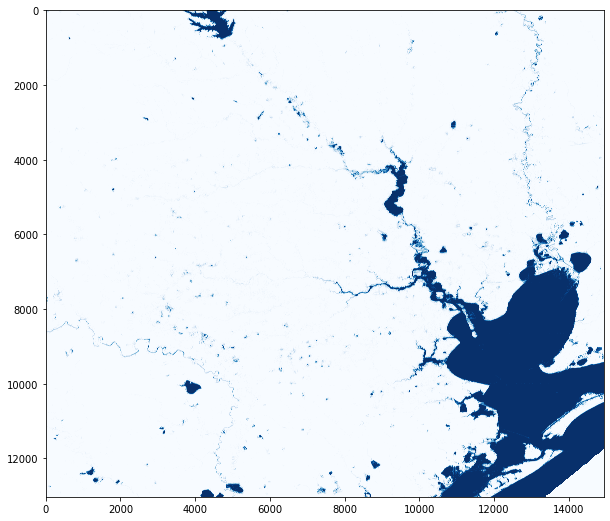

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(out[0], vmin=0, cmap="Blues")
plt.show()

In [60]:
# testing with maxed out step size
# just resample the first flood map with a few steps (testing)
start = time.time()
out = upsample_fm_with_dem(fm_paths[0], merged_dem_10m_path, steps=25, cpus=25, debug=False)

print(f"Time elapsed: {time.time() - start:0.5f} sec")

/home/nick/C2S-Python-API/c2s/hydrology/dem_upsample.py:285: RuntimeWarning: invalid value encountered in true_divide
  continuous_num_arr = np.where(votes_arr != 0, results_arr / votes_arr, nodata)


Time elapsed: 2523.54003 sec


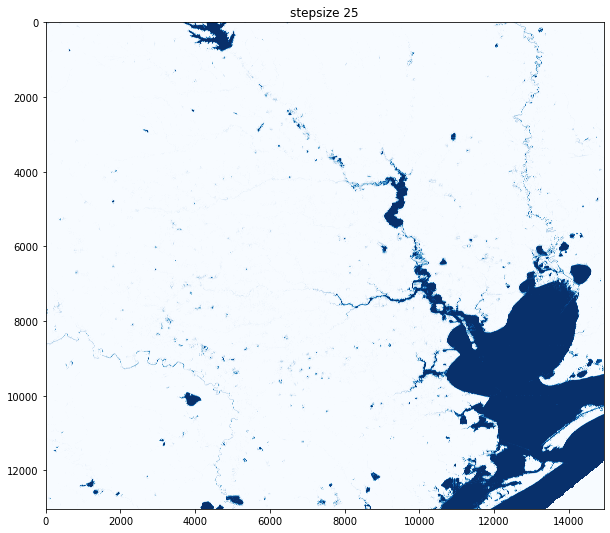

In [61]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("stepsize 25")
ax.imshow(out[0], vmin=0, cmap="Blues")
plt.show()

In [71]:
# save to geotiff so we can view in QGIS
out_profile = merged_dem_profile.copy()
out_profile["dtype"] = "uint8"
out_profile["nodata"] = 255
arr = np.where(out[0] == -9999, 255, out[0])

with rasterio.open(f"/home/nick/C2S-Python-API/data/dem_upsample/harvey/{os.path.basename(fm_paths[0]).split('.')[0]}_upsampled.tif", "w", **out_profile) as dst:
    dst.write_band(1, arr)

### Resample all FMs

In [ ]:
for fm_path in tqdm(fm_paths[1:]):
    out = upsample_fm_with_dem(fm_path, merged_dem_10m_path, steps=25, cpus=25, debug=False)[0]
    arr = np.where(out == -9999, 255, out)

    with rasterio.open(f"/home/nick/C2S-Python-API/data/dem_upsample/harvey/{os.path.basename(fm_path).split('.')[0]}_upsampled.tif", "w", **out_profile) as dst:
        dst.write_band(1, arr)

  0%|                                                                                                       | 0/12 [00:00<?, ?it/s]/home/nick/C2S-Python-API/c2s/hydrology/dem_upsample.py:285: RuntimeWarning: invalid value encountered in true_divide
  continuous_num_arr = np.where(votes_arr != 0, results_arr / votes_arr, nodata)
  8%|███████▌                                                                                   | 1/12 [42:29<7:47:20, 2549.15s/it]

In [75]:
!ls /home/nick/C2S-Python-API/data/dem_upsample/harvey/

120200_crop.tif		20170826.tif		20170901.tif
120302_crop.tif		20170826_upsampled.tif	20170901_upsampled.tif
120401_crop.tif		20170827.tif		20170902.tif
120402_crop.tif		20170827_upsampled.tif	20170902_upsampled.tif
120701_crop.tif		20170828.tif		20170903.tif
120904_crop.tif		20170828_upsampled.tif	20170903_upsampled.tif
20170823.tif		20170829.tif		20170904.tif
20170823_upsampled.tif	20170829_upsampled.tif	20170904_upsampled.tif
20170824.tif		20170830.tif		merged_dem_10m.tif
20170824_upsampled.tif	20170830_upsampled.tif	merged_dem_10m_crop.tif
20170825.tif		20170831.tif
20170825_upsampled.tif	20170831_upsampled.tif


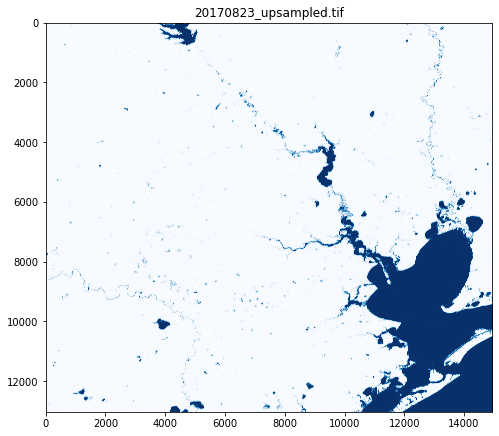

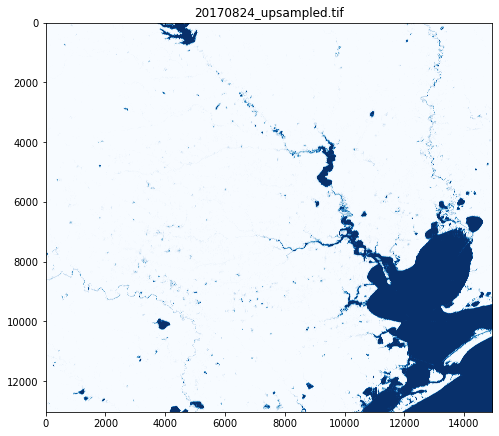

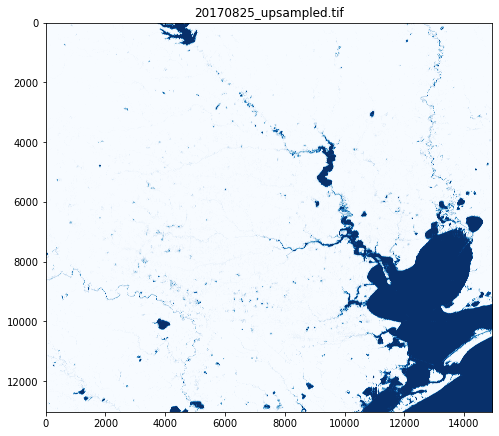

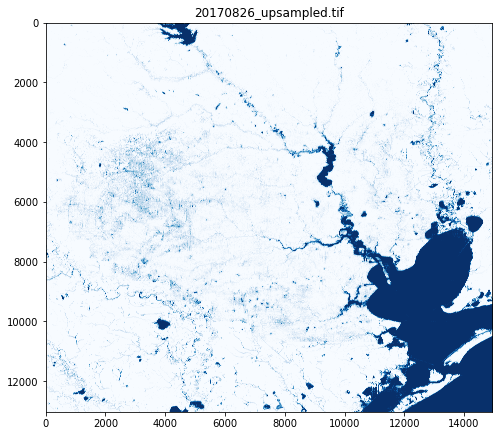

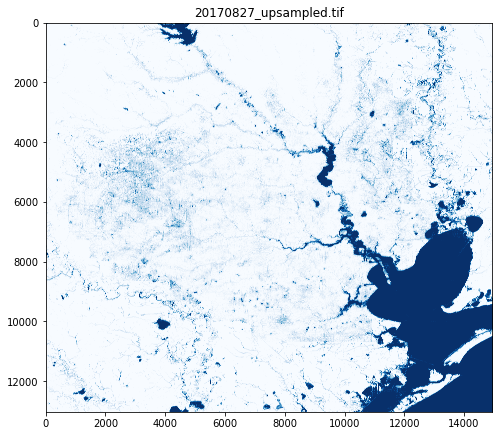

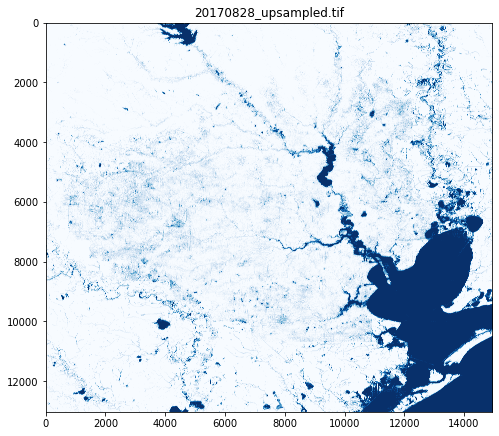

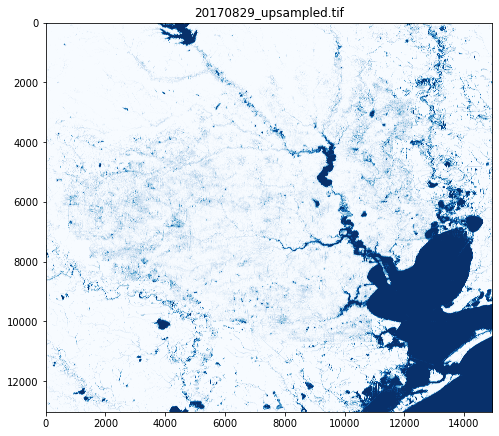

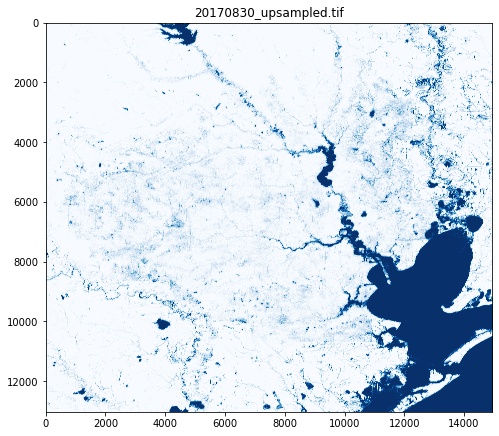

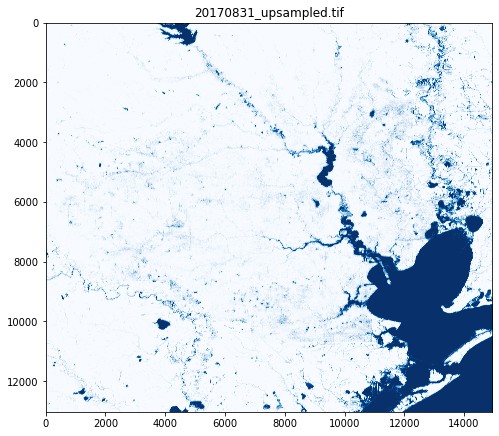

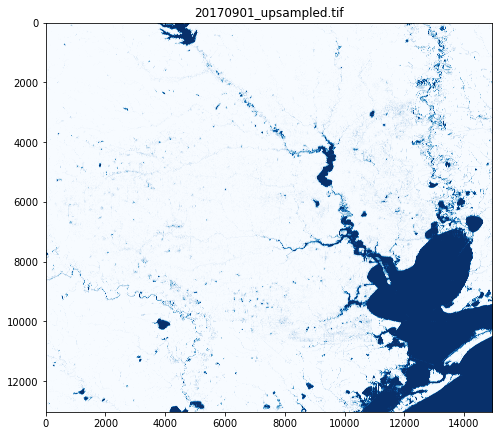

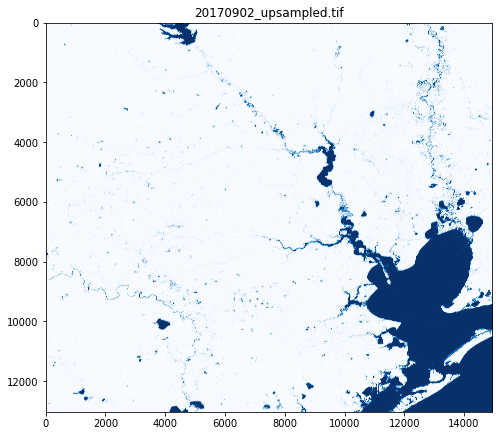

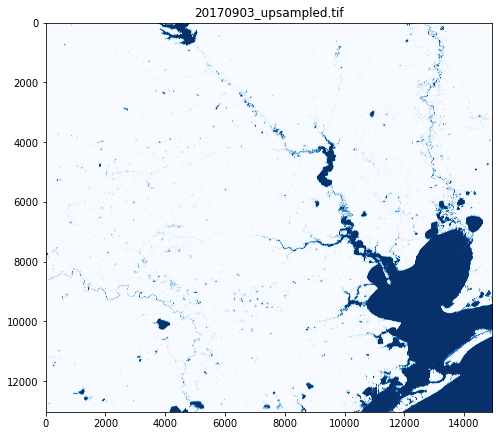

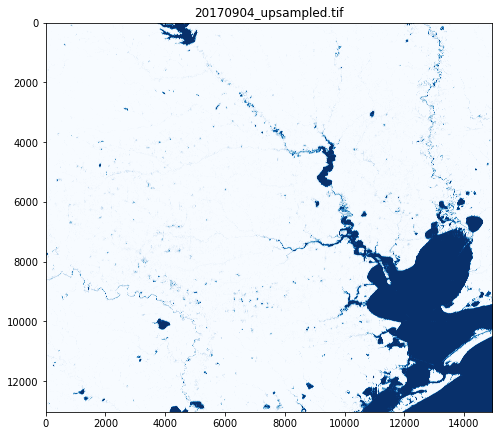

In [79]:
# visualize them all as a sanity check
for fm_path in fm_paths:
    with rasterio.open(f"/home/nick/C2S-Python-API/data/dem_upsample/harvey/{os.path.basename(fm_path).split('.')[0]}_upsampled.tif", "r") as src:
        arr = src.read(1)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(arr, vmin=0, vmax=1, cmap="Blues")
    ax.set_title(f"{os.path.basename(fm_path).split('.')[0]}_upsampled.tif")
    plt.show()

## Patricia

In [81]:
outdir = "/home/nick/C2S-Python-API/data/dem_upsample/patricia"
os.makedirs(outdir, exist_ok=True)

In [82]:
fs.ls("gs://daily_flood_v2_data/events/houston_patricia")

['daily_flood_v2_data/events/houston_patricia/20151020.tif',
 'daily_flood_v2_data/events/houston_patricia/20151021.tif',
 'daily_flood_v2_data/events/houston_patricia/20151022.tif',
 'daily_flood_v2_data/events/houston_patricia/20151023.tif',
 'daily_flood_v2_data/events/houston_patricia/20151024.tif',
 'daily_flood_v2_data/events/houston_patricia/20151025.tif',
 'daily_flood_v2_data/events/houston_patricia/20151026.tif',
 'daily_flood_v2_data/events/houston_patricia/20151027.tif',
 'daily_flood_v2_data/events/houston_patricia/20151028.tif',
 'daily_flood_v2_data/events/houston_patricia/20151029.tif',
 'daily_flood_v2_data/events/houston_patricia/20151030.tif']

In [83]:
fm_paths = []

for gs_path in fs.ls("gs://daily_flood_v2_data/events/houston_patricia"):
    if not gs_path.endswith(".tif"):
        continue
    dst_path = f"{outdir}/{os.path.basename(gs_path)}"
    print(dst_path)
    fs.get(
        gs_path,
        dst_path
    )
    fm_paths.append(dst_path)

/home/nick/C2S-Python-API/data/dem_upsample/patricia/20151020.tif
/home/nick/C2S-Python-API/data/dem_upsample/patricia/20151021.tif
/home/nick/C2S-Python-API/data/dem_upsample/patricia/20151022.tif
/home/nick/C2S-Python-API/data/dem_upsample/patricia/20151023.tif
/home/nick/C2S-Python-API/data/dem_upsample/patricia/20151024.tif
/home/nick/C2S-Python-API/data/dem_upsample/patricia/20151025.tif
/home/nick/C2S-Python-API/data/dem_upsample/patricia/20151026.tif
/home/nick/C2S-Python-API/data/dem_upsample/patricia/20151027.tif
/home/nick/C2S-Python-API/data/dem_upsample/patricia/20151028.tif
/home/nick/C2S-Python-API/data/dem_upsample/patricia/20151029.tif
/home/nick/C2S-Python-API/data/dem_upsample/patricia/20151030.tif


### DEMs are already prepared from Harvey

In [ ]:
for fm_path in tqdm(fm_paths):
    out = upsample_fm_with_dem(fm_path, merged_dem_10m_path, steps=25, cpus=25, debug=False)[0]
    arr = np.where(out == -9999, 255, out)

    with rasterio.open(f"/home/nick/C2S-Python-API/data/dem_upsample/patricia/{os.path.basename(fm_path).split('.')[0]}_upsampled.tif", "w", **out_profile) as dst:
        dst.write_band(1, arr)

  0%|                                                                                                       | 0/11 [00:00<?, ?it/s]

## Ike

In [ ]:
outdir = "/home/nick/C2S-Python-API/data/dem_upsample/ike"
os.makedirs(outdir, exist_ok=True)

In [ ]:
fs.ls("gs://daily_flood_v2_data/events/houston_ike")

In [ ]:
fm_paths = []

for gs_path in fs.ls("gs://daily_flood_v2_data/events/houston_ike"):
    if not gs_path.endswith(".tif"):
        continue
    dst_path = f"{outdir}/{os.path.basename(gs_path)}"
    print(dst_path)
    fs.get(
        gs_path,
        dst_path
    )
    fm_paths.append(dst_path)

In [ ]:
for fm_path in tqdm(fm_paths):
    out = upsample_fm_with_dem(fm_path, merged_dem_10m_path, steps=25, cpus=25, debug=False)[0]
    arr = np.where(out == -9999, 255, out)

    with rasterio.open(f"/home/nick/C2S-Python-API/data/dem_upsample/ike/{os.path.basename(fm_path).split('.')[0]}_upsampled.tif", "w", **out_profile) as dst:
        dst.write_band(1, arr)

## Laura

In [ ]:
outdir = "/home/nick/C2S-Python-API/data/dem_upsample/laura"
os.makedirs(outdir, exist_ok=True)

In [ ]:
fs.ls("gs://daily_flood_v2_data/events/houston_laura")

In [ ]:
fm_paths = []

for gs_path in fs.ls("gs://daily_flood_v2_data/events/houston_laura"):
    if not gs_path.endswith(".tif"):
        continue
    dst_path = f"{outdir}/{os.path.basename(gs_path)}"
    print(dst_path)
    fs.get(
        gs_path,
        dst_path
    )
    fm_paths.append(dst_path)

In [ ]:
for fm_path in tqdm(fm_paths):
    out = upsample_fm_with_dem(fm_path, merged_dem_10m_path, steps=25, cpus=25, debug=False)[0]
    arr = np.where(out == -9999, 255, out)

    with rasterio.open(f"/home/nick/C2S-Python-API/data/dem_upsample/laura/{os.path.basename(fm_path).split('.')[0]}_upsampled.tif", "w", **out_profile) as dst:
        dst.write_band(1, arr)

# Upload upsampled maps to GCS

In [99]:
# Harvey
root_dir = "/home/nick/C2S-Python-API/data/dem_upsample/harvey/"
local_paths = [os.path.join(root_dir, x) for x in os.listdir(root_dir) if x.endswith("upsampled.tif")]

for p in local_paths:
    remote_path = f"gs://daily_flood_v2_data/events/houston_harvey/{os.path.basename(p)}"
    print(remote_path)
    fs.put(p, remote_path)

gs://daily_flood_v2_data/events/houston_harvey/20170827_upsampled.tif
gs://daily_flood_v2_data/events/houston_harvey/20170826_upsampled.tif
gs://daily_flood_v2_data/events/houston_harvey/20170903_upsampled.tif
gs://daily_flood_v2_data/events/houston_harvey/20170904_upsampled.tif
gs://daily_flood_v2_data/events/houston_harvey/20170823_upsampled.tif
gs://daily_flood_v2_data/events/houston_harvey/20170824_upsampled.tif
gs://daily_flood_v2_data/events/houston_harvey/20170902_upsampled.tif
gs://daily_flood_v2_data/events/houston_harvey/20170830_upsampled.tif
gs://daily_flood_v2_data/events/houston_harvey/20170825_upsampled.tif
gs://daily_flood_v2_data/events/houston_harvey/20170831_upsampled.tif
gs://daily_flood_v2_data/events/houston_harvey/20170829_upsampled.tif
gs://daily_flood_v2_data/events/houston_harvey/20170901_upsampled.tif
gs://daily_flood_v2_data/events/houston_harvey/20170828_upsampled.tif


In [100]:
# Patricia
root_dir = "/home/nick/C2S-Python-API/data/dem_upsample/patricia/"
local_paths = [os.path.join(root_dir, x) for x in os.listdir(root_dir) if x.endswith("upsampled.tif")]

for p in local_paths:
    remote_path = f"gs://daily_flood_v2_data/events/houston_patricia/{os.path.basename(p)}"
    print(remote_path)
    fs.put(p, remote_path)

gs://daily_flood_v2_data/events/houston_patricia/20151023_upsampled.tif
gs://daily_flood_v2_data/events/houston_patricia/20151022_upsampled.tif
gs://daily_flood_v2_data/events/houston_patricia/20151027_upsampled.tif
gs://daily_flood_v2_data/events/houston_patricia/20151021_upsampled.tif
gs://daily_flood_v2_data/events/houston_patricia/20151028_upsampled.tif
gs://daily_flood_v2_data/events/houston_patricia/20151026_upsampled.tif
gs://daily_flood_v2_data/events/houston_patricia/20151024_upsampled.tif
gs://daily_flood_v2_data/events/houston_patricia/20151030_upsampled.tif
gs://daily_flood_v2_data/events/houston_patricia/20151020_upsampled.tif
gs://daily_flood_v2_data/events/houston_patricia/20151025_upsampled.tif
gs://daily_flood_v2_data/events/houston_patricia/20151029_upsampled.tif


In [101]:
# Harvey
root_dir = "/home/nick/C2S-Python-API/data/dem_upsample/ike/"
local_paths = [os.path.join(root_dir, x) for x in os.listdir(root_dir) if x.endswith("upsampled.tif")]

for p in local_paths:
    remote_path = f"gs://daily_flood_v2_data/events/houston_ike/{os.path.basename(p)}"
    print(remote_path)
    fs.put(p, remote_path)

gs://daily_flood_v2_data/events/houston_ike/20080919_upsampled.tif
gs://daily_flood_v2_data/events/houston_ike/20080915_upsampled.tif
gs://daily_flood_v2_data/events/houston_ike/20080918_upsampled.tif
gs://daily_flood_v2_data/events/houston_ike/20080914_upsampled.tif
gs://daily_flood_v2_data/events/houston_ike/20080913_upsampled.tif
gs://daily_flood_v2_data/events/houston_ike/20080922_upsampled.tif
gs://daily_flood_v2_data/events/houston_ike/20080923_upsampled.tif
gs://daily_flood_v2_data/events/houston_ike/20080912_upsampled.tif
gs://daily_flood_v2_data/events/houston_ike/20080917_upsampled.tif
gs://daily_flood_v2_data/events/houston_ike/20080921_upsampled.tif
gs://daily_flood_v2_data/events/houston_ike/20080920_upsampled.tif
gs://daily_flood_v2_data/events/houston_ike/20080910_upsampled.tif
gs://daily_flood_v2_data/events/houston_ike/20080911_upsampled.tif
gs://daily_flood_v2_data/events/houston_ike/20080924_upsampled.tif
gs://daily_flood_v2_data/events/houston_ike/20080916_upsampled

In [102]:
# Harvey
root_dir = "/home/nick/C2S-Python-API/data/dem_upsample/laura/"
local_paths = [os.path.join(root_dir, x) for x in os.listdir(root_dir) if x.endswith("upsampled.tif")]

for p in local_paths:
    remote_path = f"gs://daily_flood_v2_data/events/houston_laura/{os.path.basename(p)}"
    print(remote_path)
    fs.put(p, remote_path)

gs://daily_flood_v2_data/events/houston_laura/20200826_upsampled.tif
gs://daily_flood_v2_data/events/houston_laura/20200831_upsampled.tif
gs://daily_flood_v2_data/events/houston_laura/20200828_upsampled.tif
gs://daily_flood_v2_data/events/houston_laura/20200830_upsampled.tif
gs://daily_flood_v2_data/events/houston_laura/20200827_upsampled.tif
gs://daily_flood_v2_data/events/houston_laura/20200903_upsampled.tif
gs://daily_flood_v2_data/events/houston_laura/20200902_upsampled.tif
gs://daily_flood_v2_data/events/houston_laura/20200825_upsampled.tif
gs://daily_flood_v2_data/events/houston_laura/20200904_upsampled.tif
gs://daily_flood_v2_data/events/houston_laura/20200829_upsampled.tif
gs://daily_flood_v2_data/events/houston_laura/20200901_upsampled.tif
